### Time Series Forecasting using Smoothing Methods

This notebook explores time series forecasting through various smoothing techniques. Specifically, it covers the following methods:

#### Single Exponential Smoothing (SES)

- SES is a time series forecasting method for univariate data without trend or seasonal components. It applies exponential decay to past observations, assigning exponentially decreasing weights over time.

#### Double Exponential Smoothing (DES)

- DES, also known as Holt's linear trend model, extends SES to capture trends in the data. It includes two components: level and trend, making it suitable for data with linear trends but without seasonality.

#### Triple Exponential Smoothing (TES) / Holt-Winters

- TES, also known as the Holt-Winters method, further extends DES by incorporating seasonality. It includes three components: level, trend, and seasonal, making it ideal for time series data with both trend and seasonal patterns.


## Libraries

In [1]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt

warnings.filterwarnings('ignore')

## Convert Weekly Data to Monthly Data

In [2]:
'''
Data:
    Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.
    Period of Record: March 1958 - December 2001
'''
data = sm.datasets.co2.load_pandas()
y = data.data
y.head(5)  # weekly data

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [3]:
y = y['co2'].resample('MS').mean()  # monthly data
y

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64

In [4]:
y.isnull().sum()  # missing value count

5

In [5]:
y = y.fillna(y.bfill())  # backward fill
y

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
                 ...    
2001-08-01    369.425000
2001-09-01    367.880000
2001-10-01    368.050000
2001-11-01    369.375000
2001-12-01    371.020000
Freq: MS, Name: co2, Length: 526, dtype: float64

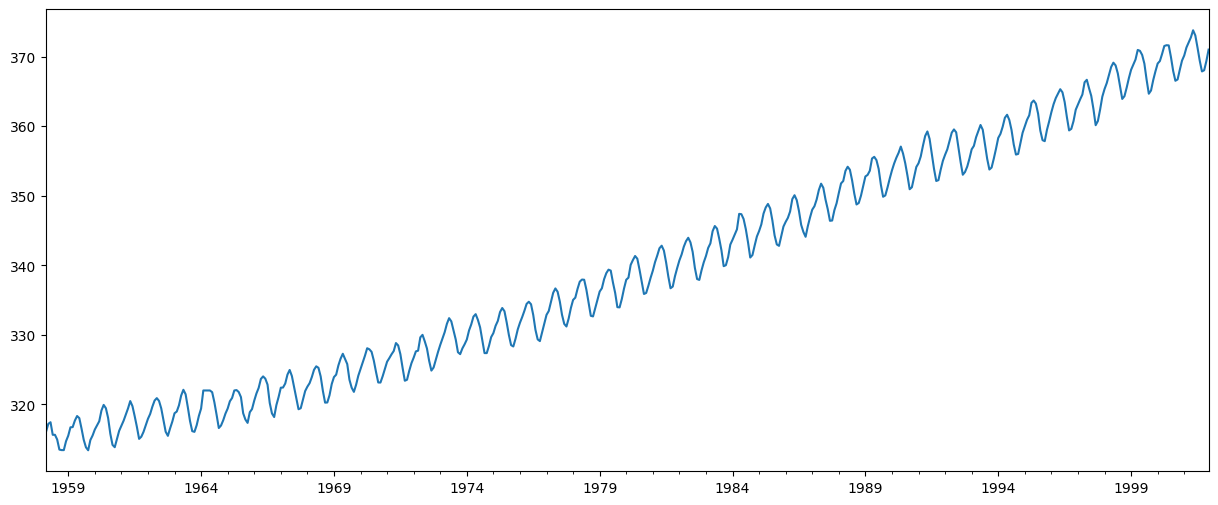

In [6]:
y.plot(figsize=(15, 6))
plt.show()

## Train/Test Split

In [7]:
train = y[:'1997-12-01']  # 478 months (%90)
test = y['1998-01-01':]   # 48 months  (%10)
print(len(train), len(test))

478 48


## Time Series Structural Analysis

In [8]:
# Dickey-Fuller Test
def is_stationary(y:pd.Series) -> None:
    # "H_O: Non-stationary"
    # "H_1: Stationary"

    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(f"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(f"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")

is_stationary(y)

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


## Time Series Components

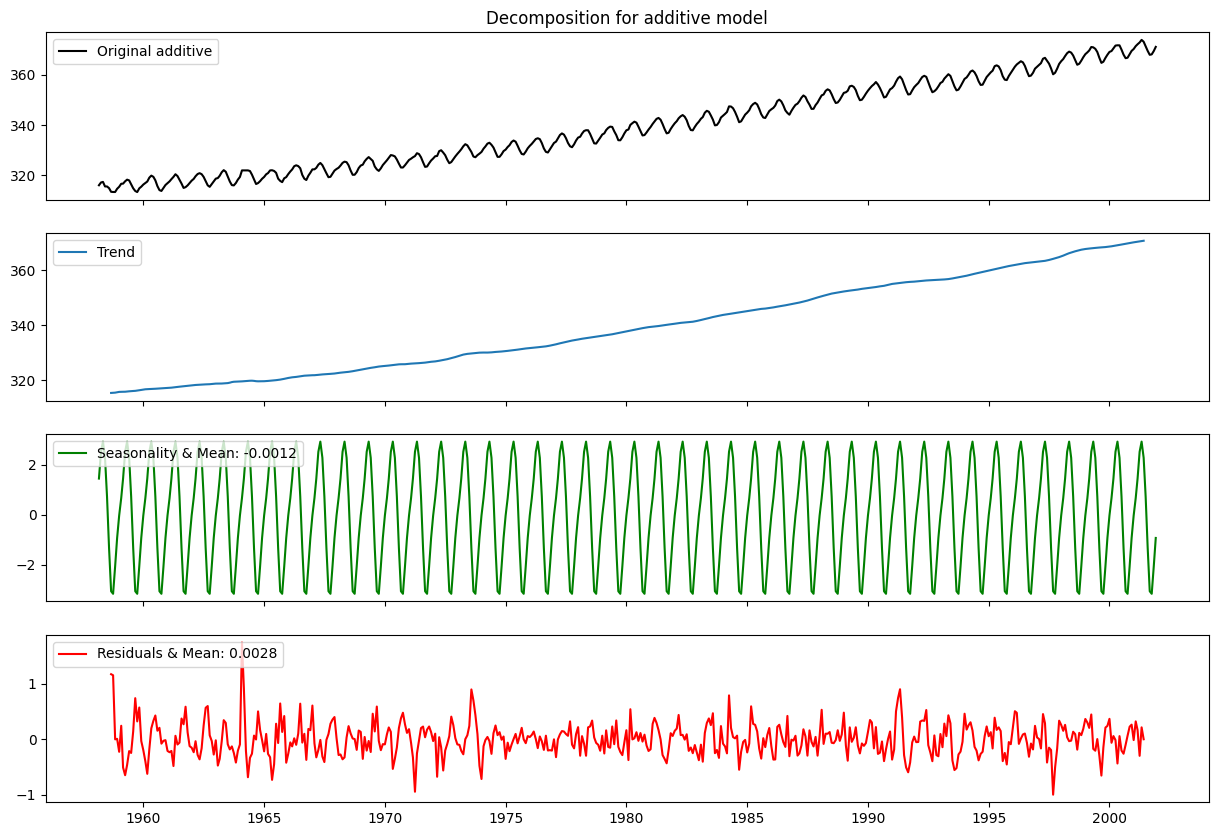

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


In [9]:
def ts_decompose(y:pd.Series,
                 model:str="additive", 
                 stationary:bool=True) -> None:
    
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(y)

ts_decompose(y, stationary=True)

## Single Exponential Smoothing Model (SES)

In [10]:
# SES = Level
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.5)
y_pred = ses_model.forecast(48)

# This time series has trend and seasonality. That's why SES is not working well!
mean_absolute_error(test, y_pred)

5.706393369643809

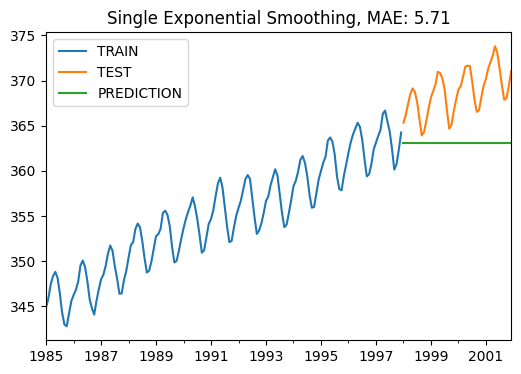

In [11]:
def plot_co2(train:pd.Series,
             test:pd.Series,
             y_pred:pd.Series,
             title:str) -> None: 
    mae = mean_absolute_error(test, y_pred)
    train["1985":].plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()

plot_co2(train, test, y_pred, "Single Exponential Smoothing")

## SES Hyperparameter Optimization

In [12]:
ses_model.params

{'smoothing_level': 0.5,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 316.1,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [13]:
# formula: yt_hat = a * (yt-1) + (1-a) * (yt-1)_hat

def ses_optimizer(train: pd.Series, 
                  alphas: np.ndarray, 
                  step: int = 48) -> (np.float64, np.float64):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

        #print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    #print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

alphas = np.arange(0.8, 1, 0.01)
best_alpha, best_mae = ses_optimizer(train, alphas)
print(f'best_alpha: {best_alpha}\nbest_mae:   {best_mae}')

best_alpha: 0.9900000000000002
best_mae:   4.545056761011273


## Final SES Model

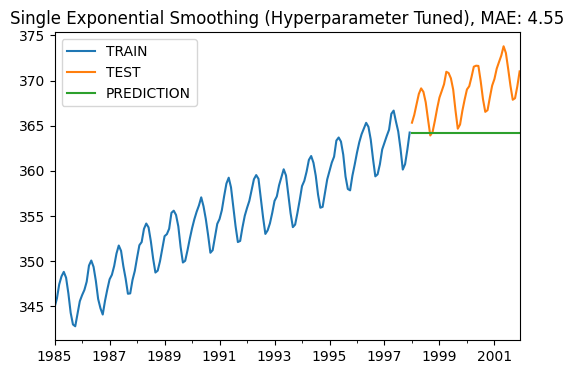

In [14]:
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(48)

plot_co2(train, test, y_pred, "Single Exponential Smoothing (Hyperparameter Tuned)")

## Double Exponential Smoothing (DES)

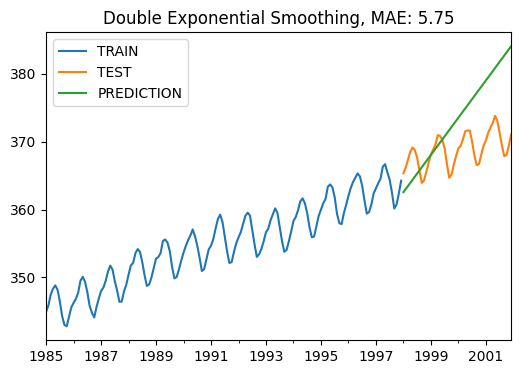

In [15]:
'''
DES: Level (SES) + Trend
y(t) = Level + Trend + Seasonality + Noise -> Additive (add)
y(t) = Level * Trend * Seasonality * Noise -> Multiplicative (mul)
'''
des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=0.5,  # alpha 
                                                         smoothing_trend=0.5   # beta
                                                        )

y_pred = des_model.forecast(48)
plot_co2(train, test, y_pred, "Double Exponential Smoothing")

## DES Hyperparameter Optimization

In [16]:
des_model.params

{'smoothing_level': 0.5,
 'smoothing_trend': 0.5,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 317.5299919184764,
 'initial_trend': -0.3037511835408663,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [17]:
def des_optimizer(train:pd.Series, 
                  alphas:np.ndarray, 
                  betas:np.ndarray, 
                  step:int=48) -> (np.float64, np.float64, np.float64):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            # print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    # print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae

alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas)
print(f'best_alpha: {best_alpha}\nbest_beta: {best_beta}\nbest_mae:   {best_mae}')

best_alpha: 0.01
best_beta: 0.7100000000000001
best_mae:   1.7411454314823693


## Final DES Model

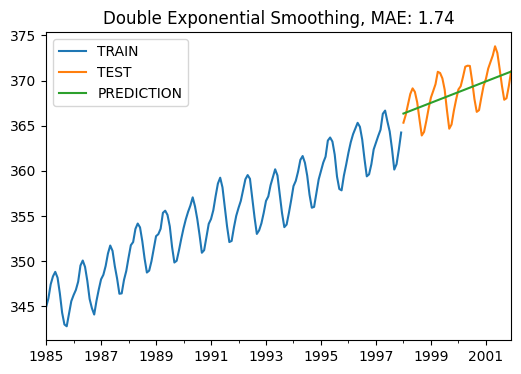

In [18]:
final_des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=best_alpha,
                                                               smoothing_slope=best_beta)

y_pred = final_des_model.forecast(48)

plot_co2(train, test, y_pred, "Double Exponential Smoothing")

## Triple Exponential Smoothing(TES) / Holt-Winters

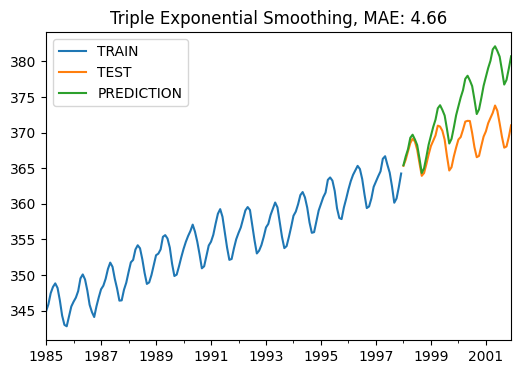

In [19]:
# TES = SES + DES + Seasonality

tes_model = ExponentialSmoothing(train,
                                 trend="add",
                                 seasonal="add",
                                 seasonal_periods=12).fit(smoothing_level=0.5,
                                                          smoothing_slope=0.5,
                                                          smoothing_seasonal=0.5)

y_pred = tes_model.forecast(48)
plot_co2(train, test, y_pred, "Triple Exponential Smoothing")

## TES Hyperparameter Optimization

In [20]:
tes_model.params

{'smoothing_level': 0.5,
 'smoothing_trend': 0.5,
 'smoothing_seasonal': 0.5,
 'damping_trend': nan,
 'initial_level': 314.9957808851727,
 'initial_trend': -0.09821733235109449,
 'initial_seasons': array([ 1.1982322 ,  2.58360471,  3.06652634,  1.06520204, -0.16408888,
        -1.30959736, -2.43959408, -2.18080681, -1.69069397, -0.83713551,
        -0.35143856,  0.56374619]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [21]:
def tes_optimizer(train:pd.Series, 
                  abg:list, 
                  step:int=48) -> (np.float64, np.float64, np.float64, np.float64):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        # print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

alphas = betas = gammas = np.arange(0.20, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))

best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg)

best_alpha: 0.8 best_beta: 0.5 best_gamma: 0.7 best_mae: 0.606


## Final TES Model

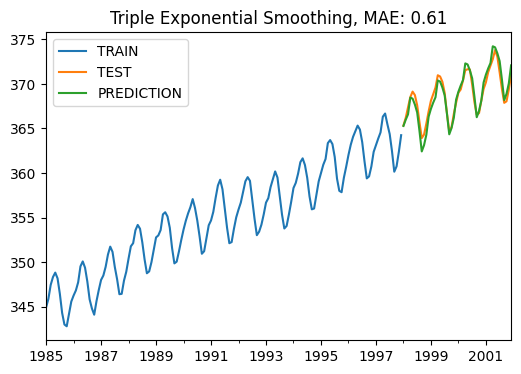

In [22]:
final_tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_trend=best_beta, smoothing_seasonal=best_gamma)

y_pred = final_tes_model.forecast(48)

plot_co2(train, test, y_pred, "Triple Exponential Smoothing")